<a href="https://colab.research.google.com/github/avinashronanki/Reddit_etl/blob/master/Network_Analysis_of_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install praw

     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 204kB 8.6MB/s 


In [2]:

import praw
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [4]:

# Authentication 
reddit = praw.Reddit(client_id='Yeoq6MgIIwS9Sg',
                     client_secret='zT6thUYquHqa9b-4U2i7Q1RXCBg',
                     user_agent='personal use script')
                    #  username='',
                    #  password='')

In [94]:

def get_posts(sub_name, n):
    subreddit = reddit.subreddit(sub_name)
    posts_list = [] 
    
    for submission in subreddit.top(limit=n):
        info_list = []
        info_list.append(submission.id)   # Output: the submission's title
        info_list.append(submission.score)  # Output: the submission's score  
        info_list.append(str(submission.author)) 
        info_list.append(submission.num_comments)
        info_list.append(submission.subreddit)
        posts_list.append(info_list)
    
    a = sorted(posts_list, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(a, columns = ['id', 'score', 'author', 'num_comments', 'subreddit'])
    return posts_df

In [95]:

def get_comments(subm_id, n): 
    
    com_list = []
    submission = reddit.submission(id = subm_id)
    i = 0
    for comment in submission.comments:
        info_list = []
            # Top 3 comments for each submission
        if i <= n:
            info_list.append(comment.id)
            info_list.append(comment.score)
            info_list.append(comment.author)
            info_list.append(submission.subreddit)
            #info_list.append(submission.comments.list()[i].body)
            i += 1
            com_list.append(info_list)
        else:
            break
    
    a = sorted(com_list, key=lambda x: x[1], reverse = True)
    com_df = pd.DataFrame(a)
    return com_df

In [96]:
def get_user_posts(author, n):
    
    redditor = reddit.redditor(author)
    user_posts_list = []
    
    for submission in redditor.submissions.top(limit = n):
        info_list = []
        info_list.append(submission.id)
        info_list.append(submission.score)
        info_list.append(str(submission.author))
        info_list.append(submission.num_comments)
        info_list.append(str(submission.subreddit))
        user_posts_list.append(info_list)
    
    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df

In [100]:
# First we scrape 1000 posts, then using submission id, scrape most popular comments of every post and append it to the 
# dataframe with comments 
df = get_posts('coronavirus', 1000)

In [101]:
df.shape # Explore posts dataframe

(985, 5)

In [102]:

df.head(10)

,id,score,author,num_comments,subreddit
0,fgi2pi,133752,finchdad,4451,Coronavirus
1,fn1mtn,122870,Franky_95,1847,Coronavirus
2,gdkt54,121826,willmannix123,2357,Coronavirus
3,hbraa5,114596,cosmicprank,2944,Coronavirus
4,fn3j0w,109930,gluuey,2212,Coronavirus
5,fxdwoa,106528,mich4725,2482,Coronavirus
6,fjcz60,101327,ssldvr,1405,Coronavirus
7,fl0pdv,101242,SingularityWalker,1294,Coronavirus
8,hwoez0,97443,NotJimIrsay,3778,Coronavirus
9,fo78n6,95090,jigsawmap,3683,Coronavirus


In [103]:
df.author.nunique()

614

In [104]:
df.subreddit.nunique()

1

In [105]:
df['score'].describe()

count       985.000000
mean      30608.008122
std       19709.146024
min       10135.000000
25%       14492.000000
50%       25434.000000
75%       41318.000000
max      133752.000000
Name: score, dtype: float64

In [106]:
df['num_comments'].describe()

count      985.000000
mean      1422.422335
std       1161.476467
min         20.000000
25%        666.000000
50%       1123.000000
75%       1827.000000
max      12364.000000
Name: num_comments, dtype: float64

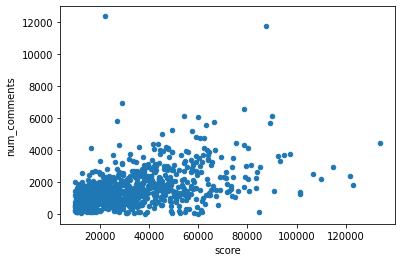

In [107]:

df.plot('score', 'num_comments', kind = 'scatter' )

Analysis based on a r/marvelstudios

In [48]:


import matplotlib.pyplot as plt

In [108]:
marvel_df = get_posts('coronavirus', 5000) 

In [109]:
marvel_df.author.nunique()

614

In [110]:
marvel_df.head()

,id,score,author,num_comments,subreddit
0,fgi2pi,133753,finchdad,4451,Coronavirus
1,fn1mtn,122863,Franky_95,1847,Coronavirus
2,gdkt54,121827,willmannix123,2357,Coronavirus
3,hbraa5,114601,cosmicprank,2944,Coronavirus
4,fn3j0w,109933,gluuey,2212,Coronavirus


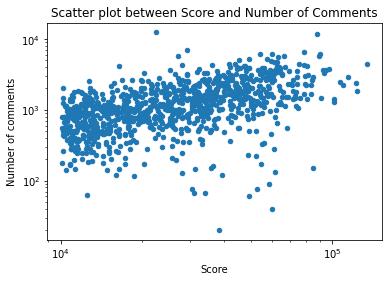

In [111]:

# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [112]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [113]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [114]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once

122

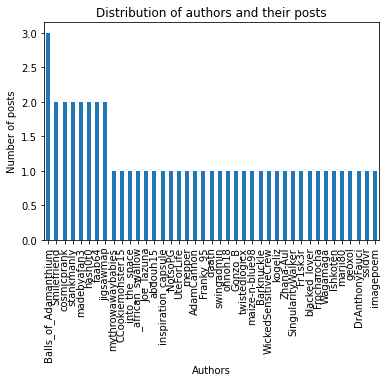

In [141]:

# See the distrubution of authors and their posts
ax = repeating[:50].author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [116]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique())

In [117]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    try:
      c = get_user_posts(u, 10)
      authors_df = pd.concat([authors_df, c])
    except:
      print('error')

error
error
error
error


In [118]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [119]:

authors_df.head(10) # Dataframe of other subreddits where authors posted

,id,score,author,num_comments,subreddit
0,fn1mtn,122866,Franky_95,1847,Coronavirus
1,fg1gcp,44440,Franky_95,3754,Coronavirus
2,ff4zkc,1404,Franky_95,245,Coronavirus
3,ffzmju,192,Franky_95,16,Coronavirus
4,fh44w2,142,Franky_95,16,Coronavirus
5,ggmuu7,34,Franky_95,0,DarioMocciaTwitch
0,hbraa5,114600,cosmicprank,2944,Coronavirus
1,g3wily,58713,cosmicprank,1650,Coronavirus
2,hrdcvi,22878,cosmicprank,830,videos
3,huk080,21712,cosmicprank,1352,Coronavirus


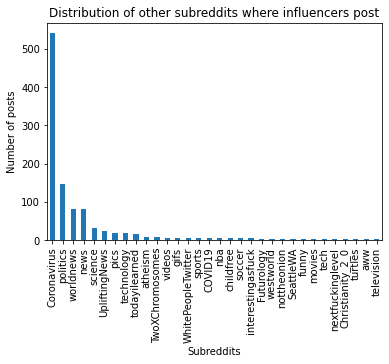

In [120]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

Network Analysis


In [121]:

n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

,author,subreddit
0,Franky_95,Coronavirus
1,Franky_95,Coronavirus
2,Franky_95,Coronavirus
3,Franky_95,Coronavirus
4,Franky_95,Coronavirus


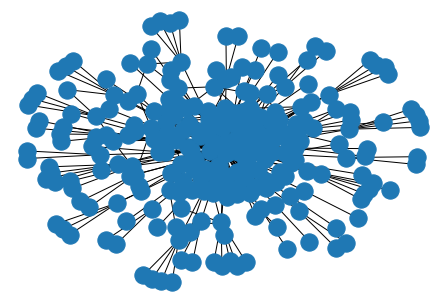

In [122]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

In [123]:

subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph

In [132]:
exclude = ['jigsawmap','Frocharocha','faab64','SunOverSnowPlease']
u_authors = [x for x in u_authors if x not in exclude]

In [ ]:
u_authors

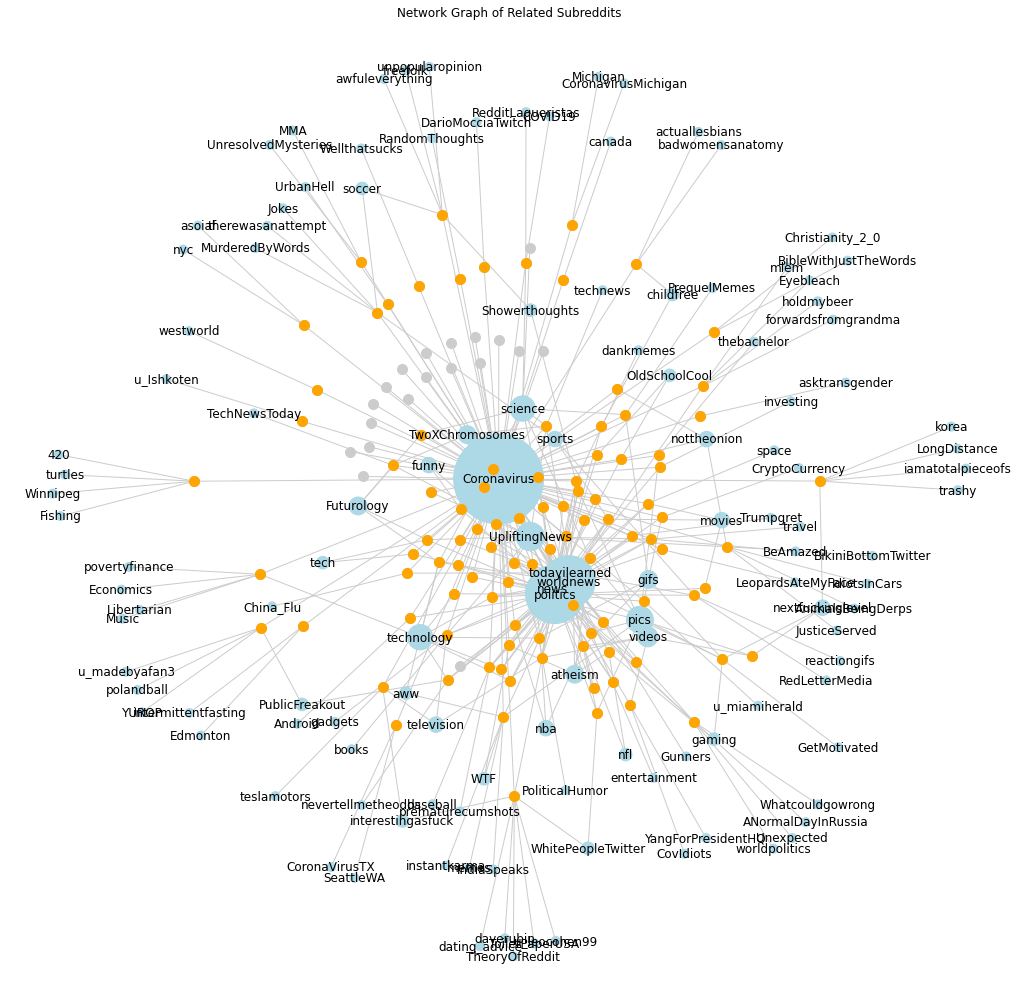

In [133]:
plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

In [136]:
g.degree('china_Flu')

DegreeView({})